<a href="https://colab.research.google.com/github/Zahidlab/OCT-classifier/blob/main/OCT_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Utils

In [1]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download...


C:\Users\HP\anaconda3\envs\zahid\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import cv2
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch import nn
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchsummary import summary

In [3]:
import torch 
import os
print(f"{'-'*20}\nTorch Version: {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'-'*20}\nUsing Device: {device}")
print("-"*20)

--------------------
Torch Version: 1.13.1
--------------------
Using Device: cuda
--------------------


In [4]:
from datetime import datetime
def get_date_time():
    a = datetime.now()
    date_time_now = a.strftime("%d_%b__%H_%M")
    return date_time_now

## Data Download

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

## Define Transform

In [6]:
IMG_SIZE = 128
trans = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    
])

In [7]:
# DATA_DIR = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\OCT2017"
DATA_DIR = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\miniOCT"
train_dataset = datasets.ImageFolder(root = os.path.join(DATA_DIR, "train") ,transform = trans)
val_dataset = datasets.ImageFolder(root = os.path.join(DATA_DIR, "val") ,transform = trans)
test_dataset = datasets.ImageFolder(root = os.path.join(DATA_DIR, "test") ,transform = trans)

# train_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/train",transform = trans)
# val_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/val" ,transform = trans)
# test_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/test", transform = trans)

In [8]:
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

## Visualizing Image

In [9]:
# from PIL import Image
# picture = Image.open('/content/drive/MyDrive/Research/Datasets/OCT2017/test/CNV/CNV-1016042-1.jpeg')
# picture.size

In [10]:
# img,label = train_dataset[random_idx]
# img.shape

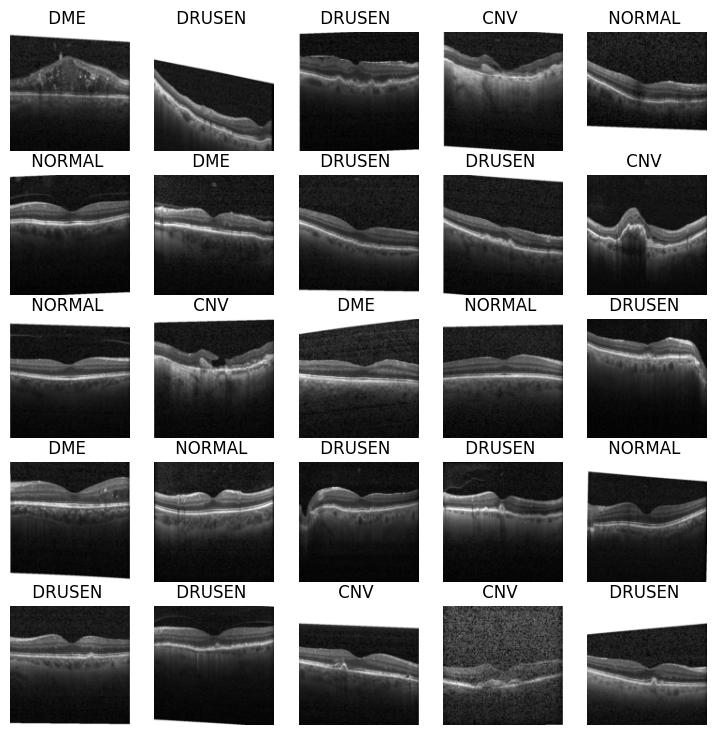

In [11]:
fig = plt.figure(figsize = (9,9))

rows,cols = 5,5

for i in range(1,rows*cols +1 ):
  random_idx = torch.randint(low = 0, high = len(train_dataset), size = (1,)).item()
  img,label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(f" {class_names[label]}  ")
  plt.axis(False)

# Batch Size

In [12]:
BATCH_SIZE = 32

## Dataloader

In [13]:


train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
    
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
    
)

print(f"Length of Train DataLoader {len(train_dataloader)} of {BATCH_SIZE} batch size")
print(f"Length of Test DataLoader {len(test_dataloader)} of {BATCH_SIZE} batch size")

Length of Train DataLoader 375 of 32 batch size
Length of Test DataLoader 31 of 32 batch size


In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Train Features Batch Shape: {train_features_batch.shape}\nTrain Labels Batch Shape {train_labels_batch.shape}")

Train Features Batch Shape: torch.Size([32, 1, 128, 128])
Train Labels Batch Shape torch.Size([32])


## Model Class

In [60]:
class OCT(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
#############################################
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

##############################################
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 
#############################################
#         nn.Conv2d(
#             in_channels = 128, 
#             out_channels = 256,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),

#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
        # 
#############################################
#         nn.Conv2d(
#             in_channels = 256, 
#             out_channels = 512,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),

#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#############################################

    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 128*30*30, out_features = 1024),
        nn.ReLU(),
#         nn.Linear(in_features = 4096, out_features = 1024),
        nn.ReLU(),
#         nn.Linear(in_features = 2048, out_features = 1024),
        nn.Linear(in_features = 1024, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)

#     print(f"Printing X Shape After Conv: {x.shape}")
    x = self.classifier(x)
#     print(f"Printing X Shape After OutPut: {x.shape}")

    return x

# 4x73728 
# (4x73728 and 25088x4)


## Creating The Model Instance

In [61]:
oct_model = OCT(input_shape= 1,
                output_shape = 4,).to(device)

In [62]:
print(f"Printing The Summary of the Model:" )
summary(oct_model, (1,IMG_SIZE,IMG_SIZE))

Printing The Summary of the Model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]             640
              ReLU-2         [-1, 64, 126, 126]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4          [-1, 128, 61, 61]          73,856
              ReLU-5          [-1, 128, 61, 61]               0
         MaxPool2d-6          [-1, 128, 30, 30]               0
           Flatten-7               [-1, 115200]               0
            Linear-8                 [-1, 1024]     117,965,824
              ReLU-9                 [-1, 1024]               0
             ReLU-10                 [-1, 1024]               0
           Linear-11                    [-1, 4]           4,100
Total params: 118,044,420
Trainable params: 118,044,420
Non-trainable params: 0
----------------------------------------------------

## Testing the Model Output

In [63]:
demo_x = torch.rand([1,1,IMG_SIZE,IMG_SIZE]).to(device)
oct_model(demo_x)

tensor([[ 0.0589, -0.0386,  0.0488, -0.0366]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [64]:
#(4x73728 and 25088x4096)

Text(0.5, 1.0, 'Random Image')

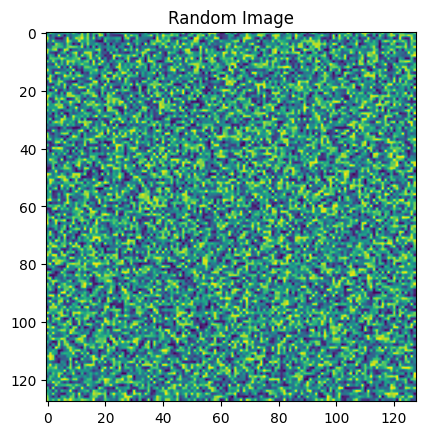

In [65]:
plt.imshow(demo_x[0].squeeze().to("cpu"))
plt.title("Random Image")

## Loss & Optimizer

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = oct_model.parameters(), 
                            lr = 0.001)


In [67]:
def acc_fn(y_true, y_pred):
    return (y_true == y_pred)/y_true[0]
    

In [68]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [69]:
# accuracy_fn(torch.tensor([0,0,0,0,0,0,0,0,]), torch.tensor([0,1,1,0,1,0,1,1,]))

In [70]:
# from torchmetrics.classification import MulticlassAccuracy

In [90]:
def evaluate_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader, 
               loss_fn : torch.nn.Module,

              accuracy_fn,
              device = device
               ):
  
  test_loss, test_acc = 0,0
  torch.manual_seed(42)
  # Evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
        
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
     
      test_acc += accuracy_fn(y, torch.argmax(y_pred, dim = 1))


      test_loss += loss_fn(y_pred, y)
    
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
 

  return {
      "model": model.__class__.__name__,
      "loss": test_loss.item(),
      "acc": test_acc,
  }

## Test Function

In [72]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader, 
               loss_fn : torch.nn.Module,

              accuracy_fn,
              device = device
               ):
  
  test_loss, test_acc = 0,0
  torch.manual_seed(42)
  # Evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X = X.to(device)
      y = y.to(device)
      test_pred = model(X)
     
      test_acc += accuracy_fn(y, torch.argmax(test_pred, dim = 1))

      test_loss += loss_fn(test_pred, y)
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
 
  
  print(f"Testing Loss:  {test_loss:.4f} | Testing Accuracy: {test_acc:.4f}\n")
  return test_loss, test_acc


## Train Function

In [73]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device = device 
               ):
  
  train_loss, train_acc = 0,0
    
  torch.manual_seed(42)
  #Training Mode
  model.train()
  
  for batch, (X,y) in enumerate(data_loader):
    
#     print(f"Batch Number{batch}")
    X = X.to(device)
    y = y.to(device)
#     print("Transferred to DEVICE")
    #forward Pass
    y_pred = model(X)
    
#     print("Got y_pred")

    #Calculate Loss & Accumulate
    loss  = loss_fn(y_pred, y)
#     print(f"LOSS: {loss.item()}")
    train_loss += loss
    
#     print("Calculated Loss")

    #Calculate Accuracy & Accumulate
    

    #Zeroing Optimizer
    optimizer.zero_grad()
    
#     print("OPtim Zeroed")

    #Backward Pass
    loss.backward()
#     print("BackWard Done")
    #Optimizer Pass
    optimizer.step()
    
#     print("Optim Step done")

    #     acc = accuracy_score(y, torch.argmax(y_pred, dim = 1))
    acc = accuracy_fn(y, torch.argmax(y_pred, dim = 1))
#     print(f"ACC: {acc}")
    train_acc+= acc
#     print("Calculated ACC")


#     print("-"*20)

  #Calculating Average Accuracy & Loss
  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  
  
  print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}\n")
  return train_loss, train_acc


In [74]:
# from helper_functions import accuracy_fn
# loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
# optimizer = torch.optim.SGD(params=Classifier_Model.parameters(), # tries to update our model's parameters to reduce the loss 
#                             lr=0.1)

## Train - Test

In [75]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
start = timer()
torch.manual_seed(42)
LOG = []
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n--------")


  train_loss, train_acc = train_step(model=oct_model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             )
  

    
  test_loss, test_acc = test_step(model = oct_model,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            )
  LOG.append([epoch, train_loss ,train_acc, test_loss, test_acc, get_date_time()])
    
total_time = timer() - start

print(f"Total Spent time: {total_time/60} Minute")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
--------
Training Loss: 1.2542 | Training Accuracy: 44.9000



 10%|█         | 1/10 [01:16<11:31, 76.88s/it]

Testing Loss:  0.9778 | Testing Accuracy: 59.7782

Epoch: 1 
--------
Training Loss: 0.8823 | Training Accuracy: 63.3167



 20%|██        | 2/10 [02:33<10:15, 76.98s/it]

Testing Loss:  0.8050 | Testing Accuracy: 67.5403

Epoch: 2 
--------
Training Loss: 0.7193 | Training Accuracy: 72.0000



 30%|███       | 3/10 [03:50<08:58, 76.94s/it]

Testing Loss:  0.7565 | Testing Accuracy: 68.1452

Epoch: 3 
--------
Training Loss: 0.5988 | Training Accuracy: 76.9833



 40%|████      | 4/10 [05:07<07:41, 76.84s/it]

Testing Loss:  0.7803 | Testing Accuracy: 69.5565

Epoch: 4 
--------
Training Loss: 0.4861 | Training Accuracy: 81.7583



 50%|█████     | 5/10 [06:25<06:25, 77.18s/it]

Testing Loss:  0.6614 | Testing Accuracy: 74.1935

Epoch: 5 
--------
Training Loss: 0.3941 | Training Accuracy: 85.5500



 60%|██████    | 6/10 [07:42<05:08, 77.03s/it]

Testing Loss:  0.7474 | Testing Accuracy: 73.1855

Epoch: 6 
--------
Training Loss: 0.3139 | Training Accuracy: 88.8833



 70%|███████   | 7/10 [08:59<03:51, 77.23s/it]

Testing Loss:  0.7445 | Testing Accuracy: 75.5040

Epoch: 7 
--------
Training Loss: 0.2602 | Training Accuracy: 90.8750



 80%|████████  | 8/10 [10:18<02:35, 77.60s/it]

Testing Loss:  0.7254 | Testing Accuracy: 77.9234

Epoch: 8 
--------
Training Loss: 0.2157 | Training Accuracy: 92.5500



 90%|█████████ | 9/10 [11:35<01:17, 77.58s/it]

Testing Loss:  0.7599 | Testing Accuracy: 79.1331

Epoch: 9 
--------
Training Loss: 0.1778 | Training Accuracy: 93.9917



100%|██████████| 10/10 [12:52<00:00, 77.26s/it]

Testing Loss:  0.8575 | Testing Accuracy: 77.5202

Total Spent time: 12.877015927166667 Minute


In [91]:
result = evaluate_model(model = oct_model,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn)


In [92]:
result

{'model': 'OCT', 'loss': 0.8574862480163574, 'acc': 77.52016129032258}

In [79]:
# import random
# test_images = []
# test_labels = []


# for image, label in random.sample(list(test_data), k = 16):
#   test_images.append(image)
#   test_labels.append(label)


NameError: name 'test_data' is not defined

In [ ]:
# def visualize_test_images(test_data, model:torch.nn.Module, count = 9):

#   ### Sampling
#   test_images = []
#   test_labels = []

#   for image, label in random.sample(list(test_data), k = count):
#     test_images.append(image)
#     test_labels.append(label)

#   ### Making Prediction
#   model.eval()
#   pred_labels = []
#   with torch.inference_mode():
#     for image in test_images:
#       # print(image.shape)
#       image = image.unsqueeze(dim=0)
#       # print(image.shape)

#       pred_logits = model(image)
#       pred_logits = pred_logits.squeeze()

#       pred_proba = torch.softmax(pred_logits, dim=0)

#       pred_label = pred_proba.argmax()
#       pred_labels.append(pred_label.item())
    
#       # print(f"Logits Shape -> {pred_logits.shape} | Logits -> {pred_logits}")
#       # print(f"Proba Shape -> {pred_proba.shape} | Proba -> {pred_proba}")
#       # print(f"Label Shape -> {pred_label.shape} | Label -> {pred_label}")

  


#   ### Visualize
#   plt.figure(figsize = (9,9))
#   rows = 3
#   cols = 3

#   for i,sample in enumerate(test_images):
#     plt.subplot(rows, cols, i+1)

#     plt.imshow(sample.squeeze(), cmap = 'gray')

#     pred_label = class_names[pred_labels[i]]
#     real_label = class_names[test_labels[i]]
    
#     if pred_label == real_label:
#       plt.title(f"Real {real_label} || Pred: {pred_label}",fontsize=10, c = 'g')
#     else:
#       plt.title(f"Real {real_label} || Pred: {pred_label}",fontsize=10, c = 'r')

#     plt.axis(False)




In [ ]:
# visualize_test_images(test_data=test_data, model=cnn_model, count = 9 )



In [ ]:
# test_images[0].unsqueeze(dim=0).shape

## Saving Results to CSV file


In [93]:
from csv import writer
path_to_csv = r'C:\Users\HP\Documents\Zahid\OCT\Results\results.csv'

with open(path_to_csv, "a") as result_csv:
    writer_obj = writer(result_csv)
    writer_obj.writerow(result.values())
    
    result_csv.close()

In [94]:
import pandas as pd
df = pd.read_csv(r'C:\Users\HP\Documents\Zahid\OCT\Results\results.csv')
df

,model,loss,acc
0,OCT,"tensor(0.8575, device='cuda:0')",77.520161
1,OCT,0.8574862480163574,77.520161


In [ ]:
torch.cuda.empty_cache()

## Saving Model

In [96]:
def get_name(model_name):
    
    return model_name+" "+get_date_time()+".pth"

In [99]:
from pathlib import Path
model_folder_path = Path("Models")
model_folder_path.mkdir(parents=True, exist_ok=True )

model_name = get_name("OCT_Classifier")
model_save_path = model_folder_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj=oct_model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=model_save_path)

Saving model to: Models\OCT_Classifier 15_Feb__15_53.pth
